In [35]:
import warnings
warnings.filterwarnings('ignore')
import pyart
%pylab inline
import cartopy.crs as ccrs

Populating the interactive namespace from numpy and matplotlib


In [40]:
radar = pyart.io.read('../inf_tutorial_data/csapr_test_case.nc')

The radial velocity measured by the radar is mesasured by detecing the phase shift between the transmitted pulse and the pulse recieved by the radar. However, using this methodology, it is only possible to detect phase shifts within $\pm 2\pi$ due to the periodicity of the transmitted wave. Therefore, for example, a phase shift of $3\pi$ would erroneously be detected as a phase shift of $-\pi$ and give an incorrect value of velocity when retrieved by the radar. This phenomena is called aliasing. The maximium unambious velocity that can be detected by the radar before aliasing occurs is called the Nyquist velocity.

In the next example, you will see an example of aliasing occurring, where the values of +15 m/s abruptly transition into a region of -15 m/s, with -5 m/s in the middle of the region around 37 N, 97 W.

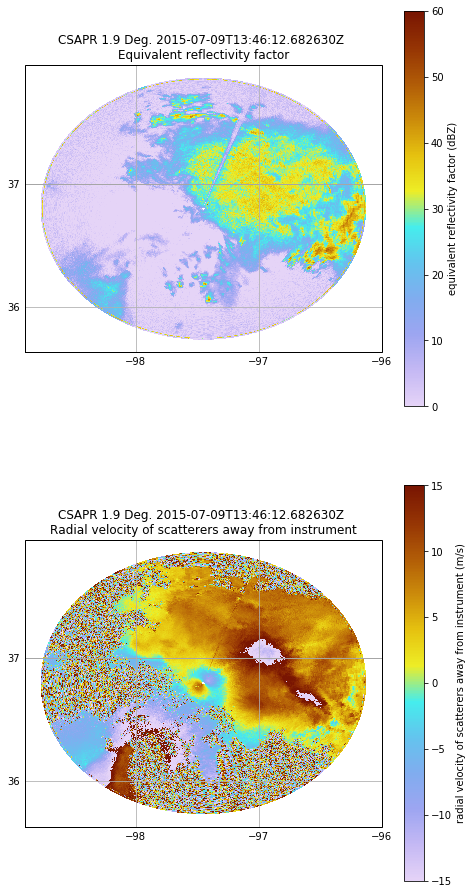

In [50]:
fig = plt.figure(figsize=[8,16])
ax = plt.subplot(2,1,1,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map('reflectivity', sweep=2, resolution='50m',
                     vmin=0, vmax=60, 
                     projection=ccrs.PlateCarree(), cmap='pyart_LangRainbow12')

ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map('velocity', sweep=2, resolution='50m',
                     vmin=-15, vmax=15, 
                     projection=ccrs.PlateCarree(), cmap='pyart_LangRainbow12')
plt.show()

First, for dealiasing to work efficiently, we need to use a GateFilter. Notice that, this time, the data shown does not give us a nice gate_id. This is what raw data looks like, and we need to do some preprocessing on the data to remove noise and clutter. Thankfully, Py-ART gives us the capability to do this. As a simple filter in this example, we will first calculate the velocity texture using Py-ART's calculate_velocity_texture function. The velocity texture is the standard deviation of velocity surrounding a gate. This will be higher in the presence of noise.

In [53]:
vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='velocity', wind_size=3, nyq=13.1)
radar.add_field('texture', vel_texture, replace_existing=True)

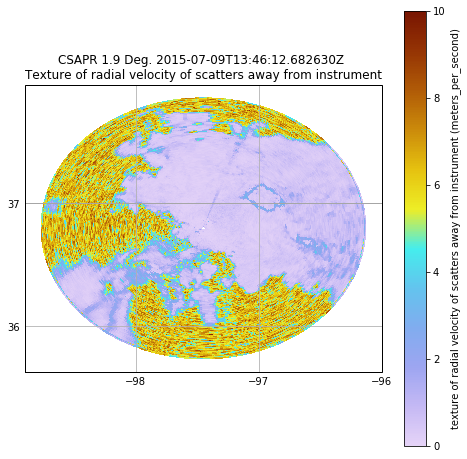

In [54]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map('texture', sweep=2, resolution='50m',
                     vmin=0, vmax=10, 
                     projection=ccrs.PlateCarree(), cmap='pyart_LangRainbow12')
plt.show()

Plot a histogram of velocity texture to get a better idea of what values correspond to hydrometeors and what values of texture correspond to artifacts.

In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.

Text(0,0.5,'Count')

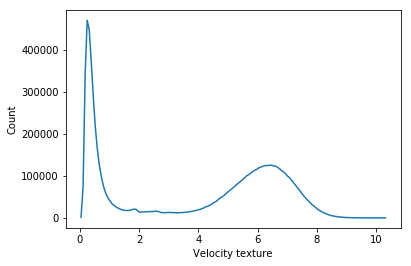

In [58]:
hist, bins = np.histogram(radar.fields['texture']['data'], bins=150)
bins = (bins[1:]+bins[:-1])/2.0
plt.plot(bins, hist)
plt.xlabel('Velocity texture')
plt.ylabel('Count')

Now we can set up our GateFilter!

In [59]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('texture', 3)

Now let us view the filtered result!

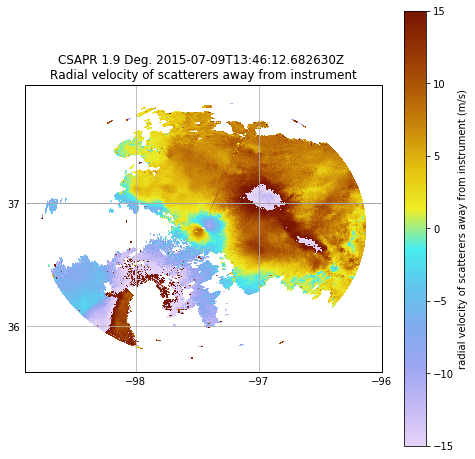

In [61]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map('velocity', sweep=2, resolution='50m',
                     vmin=-15, vmax=15, 
                     projection=ccrs.PlateCarree(), cmap='pyart_LangRainbow12',
                     gatefilter=gatefilter)
plt.show()

At this point, we can simply used dealias_region_based to dealias the velocities and then add the new field to the radar!

In [64]:
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
velocity_dealiased = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                        centered=True, gatefilter=gatefilter)
radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

Plot the new velocities, which now look much more realistic.

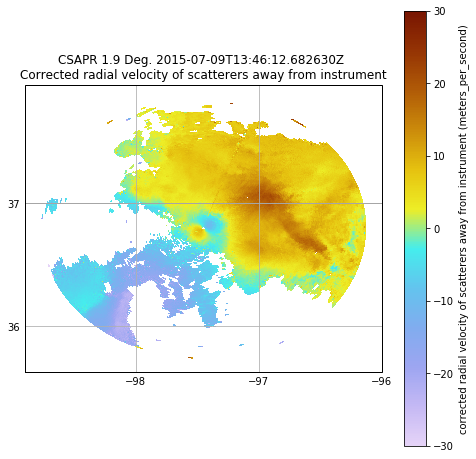

In [65]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
display.plot_ppi_map('corrected_velocity', sweep=2, resolution='50m',
                     vmin=-30, vmax=30, 
                     projection=ccrs.PlateCarree(), cmap='pyart_LangRainbow12',
                     gatefilter=gatefilter)
plt.show()

## Exercise

Try dealiasing a file from CPOL yourself: ../inf_tutorial_data/cfrad.20060120_005000.000_to_20060120_005810.000_CPOL_PPI_level1a.nc. The Nyquist velocity of the CPOL radar is 13.8 $m\ s^{-1}$

In [ ]:
%load section1_answer.py